<a href="https://colab.research.google.com/github/whoiskiki/WineQuialityResearch/blob/master/WineQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация

Рассматривается датасет **wine-quality-red**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, classification_report, auc, roc_auc_score, confusion_matrix
#%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

red_wine = fetch_openml(name='wine-quality-red', version=1, as_frame=True)
dataf = pd.DataFrame(red_wine['data'], columns=red_wine['feature_names'])
dataf['target'] = red_wine['target']

In [ ]:
def check_data(df: pd.DataFrame):
    print('\nShort sample')
    print(df.head())

    print("\nTypes")
    print(df.dtypes)

    print("\nMin amd max in Feature")
    for i in df.columns:
        print(f"{i}: {(min(df[i]), max(df[i]))}")

    print("\nNANs")
    print(df.isnull().sum())

    print('\n Unique values')
    print(df.apply(lambda x: len(x.unique())))


check_data(dataf)


Short sample
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol target  
0      9.4      5  
1      9.8      5  
2      9.8  

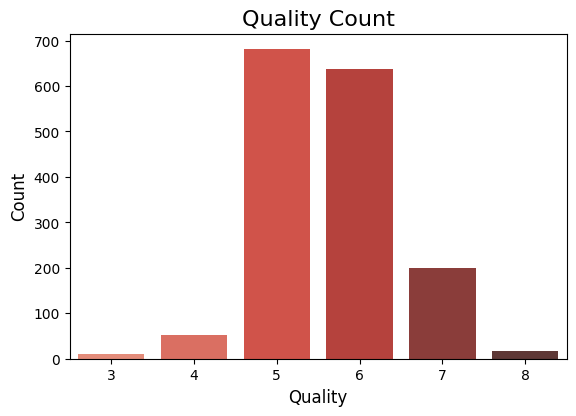

In [ ]:
sns.countplot(
    data=dataf,
    x='target',
    palette='Reds_d',
)

plt.title('Quality Count', fontsize=16)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

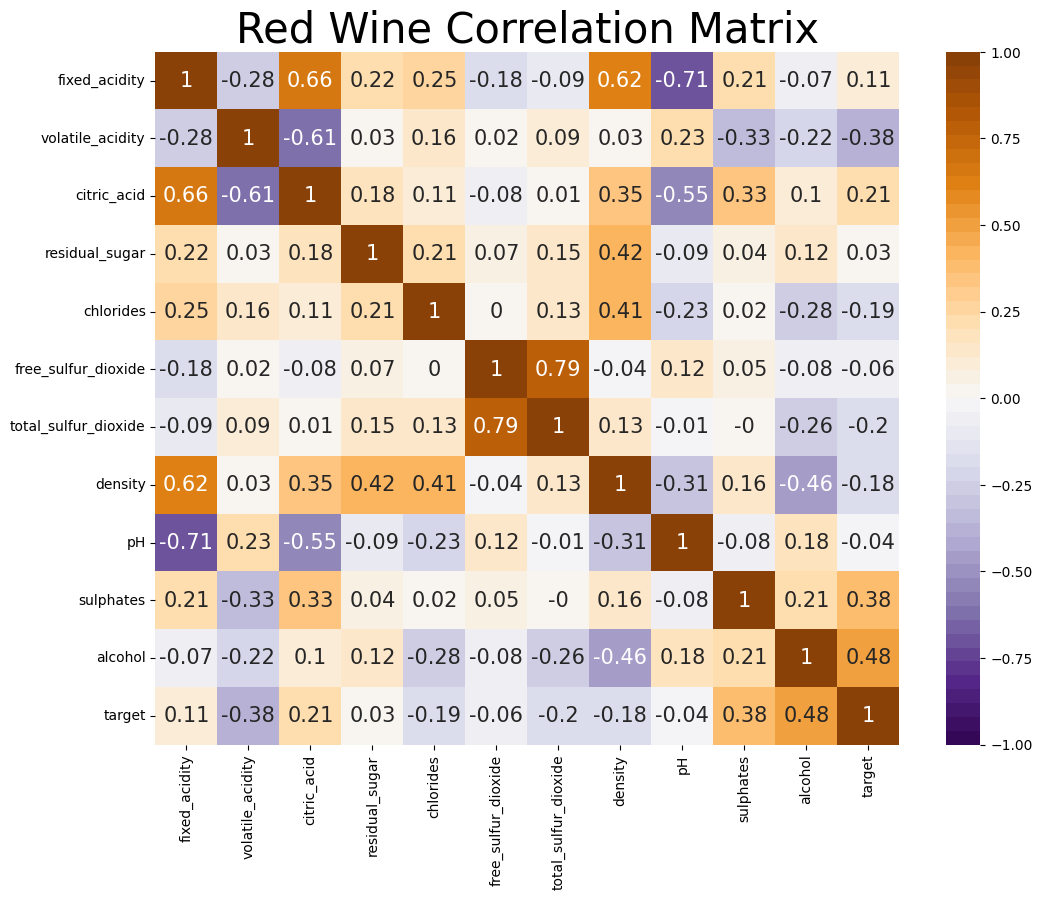

In [ ]:
def confusion_matrix_plot(data, title, height=9, width=12):
    conf_mat = round(data.corr(method="spearman"), 2)
    plt.figure(figsize=(width, height))
    ax = sns.heatmap(conf_mat, annot=True, annot_kws={"size": 15}, cmap=sns.color_palette("PuOr_r", 50),
                     vmin=-1, vmax=1)

    ax.axes.set_title(title, fontsize=30)
    ax.title.set_position([.5, 1.03])
    plt.show()


confusion_matrix_plot(dataf, title="Red Wine Correlation Matrix")

In [ ]:
dataf['target'] = dataf['target'].cat.codes
#print(dataf['target'].dtype)

dataf = dataf.replace({'target': {
    5: 1,
    4: 1,
    3: 0,
    2: 0,
    1: 0,
    0: 0,
}})

print(dataf['target'].value_counts())

X = dataf.drop('target', axis=1).values
y = dataf['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52, stratify=y)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test", y_test.shape)

target
0    1382
1     217
Name: count, dtype: int64
Shape of X_train:  (1279, 11)
Shape of X_test:  (320, 11)
Shape of y_train:  (1279,)
Shape of y_test (320,)


In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2]
for i in lr_list:
    boosting = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=i, max_depth=4,
        min_samples_split=5, min_samples_leaf=2,
        subsample=1.0, random_state=52)
    boosting.fit(X_train, y_train)

    print("Learning rate: ", i)
    print("Accuracy score (training): {0:.3f}".format(boosting.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(boosting.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.971
Accuracy score (validation): 0.906
Learning rate:  0.075
Accuracy score (training): 0.980
Accuracy score (validation): 0.900
Learning rate:  0.1
Accuracy score (training): 0.991
Accuracy score (validation): 0.900
Learning rate:  0.15
Accuracy score (training): 0.998
Accuracy score (validation): 0.894
Learning rate:  0.2
Accuracy score (training): 1.000
Accuracy score (validation): 0.903


In [ ]:
models = {}
model_info = []

boosting = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05, max_depth=11,
    min_samples_split=6, min_samples_leaf=2, random_state=52)

models['GradientBoostingClassifier'] = boosting


### При n_estimators == 200 и random_state == 33 получается точность на тесте 0.9 (suspicious....)
xgBoosting = XGBClassifier(
    booster='gbtree',
    n_estimators=500,
    learning_rate=0.15,
    max_depth=2,
    alpha=0.001,
    min_sample_leaf=1,
    random_state=33)
models['XGBoostingClassifier'] = xgBoosting

catBoosting = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=8,
    random_seed=52,
    l2_leaf_reg=1,
    silent=True)

models['CatBoostClassifier'] = catBoosting

In [ ]:
def evaluate_model(model, model_name: str):
    model.fit(X_train, y_train)
    score_test = model.score(X_test, y_test)
    score_train = model.score(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f'{model_name}:')
    print(classification_report(y_test, y_pred))
    print('')
    print("Accuracy score (training): {0:.3f}".format(model.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(model.score(X_test, y_test)))
    print('')

    tp = confusion_matrix(y_test, y_pred)[0, 0]
    fp = confusion_matrix(y_test, y_pred)[0, 1]
    tn = confusion_matrix(y_test, y_pred)[1, 1]
    fn = confusion_matrix(y_test, y_pred)[1, 0]

    model_info.append((model_name, tp, fp, tn, fn, score_train, score_test))

    return y_pred


boosting_predict = evaluate_model(boosting, 'GradientBoostingClassifier')
XG_predict = evaluate_model(xgBoosting, 'XGBoostingClassifier')
cat_predict = evaluate_model(catBoosting, 'CatBoostClassifier')

GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       277
           1       0.64      0.49      0.55        43

    accuracy                           0.89       320
   macro avg       0.78      0.72      0.75       320
weighted avg       0.88      0.89      0.89       320


Accuracy score (training): 1.000
Accuracy score (validation): 0.894

XGBoostingClassifier:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       277
           1       0.62      0.49      0.55        43

    accuracy                           0.89       320
   macro avg       0.77      0.72      0.74       320
weighted avg       0.88      0.89      0.89       320


Accuracy score (training): 0.994
Accuracy score (validation): 0.891

CatBoostClassifier:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       277
           1       0.69    

Area under ROC curve = 0.89
Area under ROC curve = 0.89
Area under ROC curve = 0.90


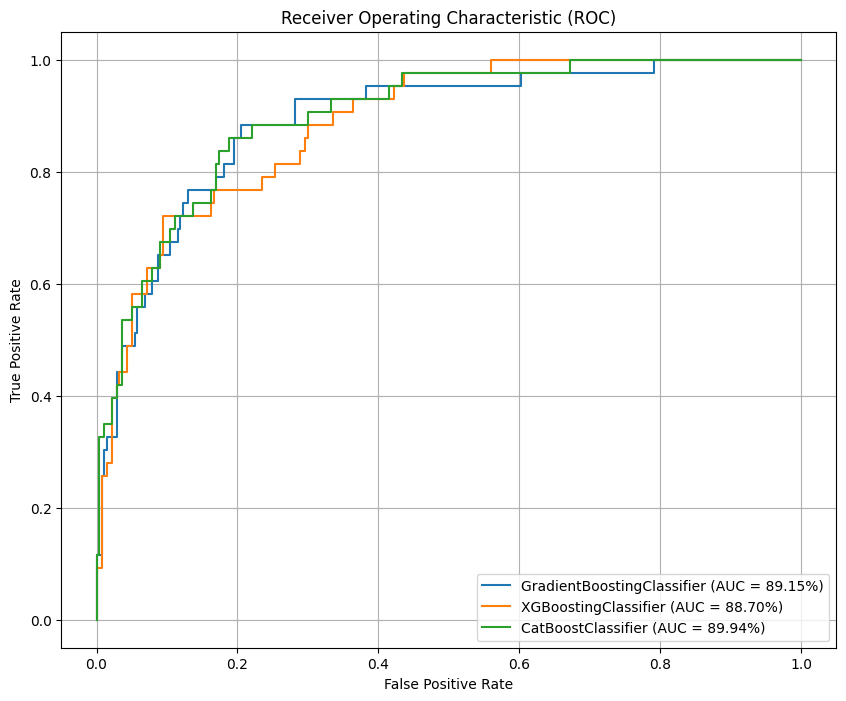

In [ ]:
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    if model_name == 'GradientBoostingClassifier':
        y_scores = model.decision_function(X_test)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)

    roc_auc_gb = auc(fpr, tpr)
    print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

    roc_auc = roc_auc_score(y_test, y_scores)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc * 100:.2f}%)')

plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

conf_mat = confusion_matrix(y_test, cat_predict)


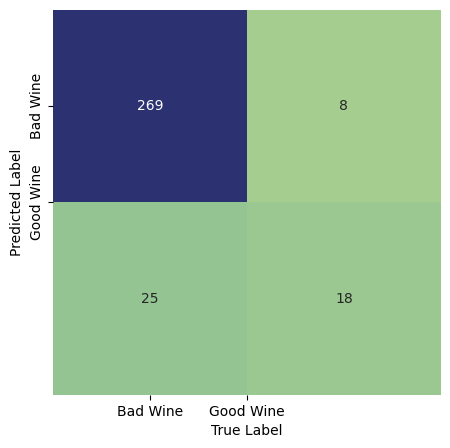

In [ ]:
def plot_conf_mat(conf_mat):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = sns.heatmap(conf_mat, annot=True, fmt='.0f', cbar=False, cmap="crest")
    plt.xticks(ticks=[.5, 1], labels=['Bad Wine', 'Good Wine'])
    plt.yticks(ticks=[.5, 1], labels=['Bad Wine', 'Good Wine'])
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.show()


plot_conf_mat(conf_mat)

In [ ]:
grid = {
    'criterion': ['squared_error', 'friedman_mse'],
    'max_depth': [i for i in range(3, 15, 2)],
    'max_features': ["log2", 'sqrt'],
    'min_samples_leaf': [2],
    'min_samples_split': [6],
    'n_estimators': [50, 100, 150]
}

params = {'iterations': [100, 500],
          'depth': [4, 6, 8],
          'learning_rate': [0.05, 0.1],
          'l2_leaf_reg': [1, 3, 5],
          'random_seed': [52]
          }

grid2 = {
    'xgb__n_estimators': [500],
    'xgb__max_depth': [2, 3, 4, 5],
    'xgb__alpha': [0.001, 0.01, 0.1, 1],
    'xgb__min_samples_leaf': [1, 2, 3]
}

dtr_model = GridSearchCV(xgBoosting, grid2, scoring='accuracy', cv=StratifiedKFold(n_splits=5))
dtr_model.fit(X=X_train, y=y_train)
print(f'Best score: {dtr_model.best_score_}')
print(f'Лучшие найденные параметры: {dtr_model.best_params_}')

Best score: 0.9100919117647059
Лучшие найденные параметры: {'xgb__alpha': 0.001, 'xgb__max_depth': 2, 'xgb__min_samples_leaf': 1, 'xgb__n_estimators': 500}


In [ ]:
comparison = pd.DataFrame(data=model_info, columns=['Model', 'True Positive', 'False Positive',
                                                    'True Negative', 'False Negative',
                                                    'Accuracy (Training)', 'Accuracy (Test)'])

pd.set_option('display.max_rows', None)  # Показать все строки
pd.set_option('display.max_columns', None)  # Показать все столбцы

print(comparison)

                        Model  True Positive  False Positive  True Negative  \
0  GradientBoostingClassifier            265              12             21   
1        XGBoostingClassifier            264              13             21   
2          CatBoostClassifier            269               8             18   

   False Negative  Accuracy (Training)  Accuracy (Test)  
0              22             1.000000         0.893750  
1              22             0.993745         0.890625  
2              25             1.000000         0.896875  


# Регрессия

In [ ]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

Используется датасет **Insurance-Premium-Data**

**age**: age of primary beneficiary

**sex**: insurance contractor gender, female, male

**bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight ($\frac{kg}{m}^2$) using the ratio of height to weight, ideally
$18.5$ to $24.9$

**children**: Number of children covered by health insurance / Number of dependents

**smoker**: Smoking

**region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

**charges**: Individual medical costs billed by health insurance

In [ ]:
insurance = fetch_openml(name='Insurance-Premium-Data', as_frame=True)
dataf = pd.DataFrame(insurance['data'], columns=insurance['feature_names'])

print(dataf.head())
print(dataf.shape)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
(1338, 7)


In [ ]:
def check_data(df: pd.DataFrame):
    print('\nShort sample')
    print(df.head())

    print("\nTypes")
    print(df.dtypes)

    print("\nNANs")
    print(df.isnull().sum())

    print('\n Unique values')
    print(df.apply(lambda x: len(x.unique())))


check_data(dataf)


Short sample
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Types
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

NANs
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

 Unique values
age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


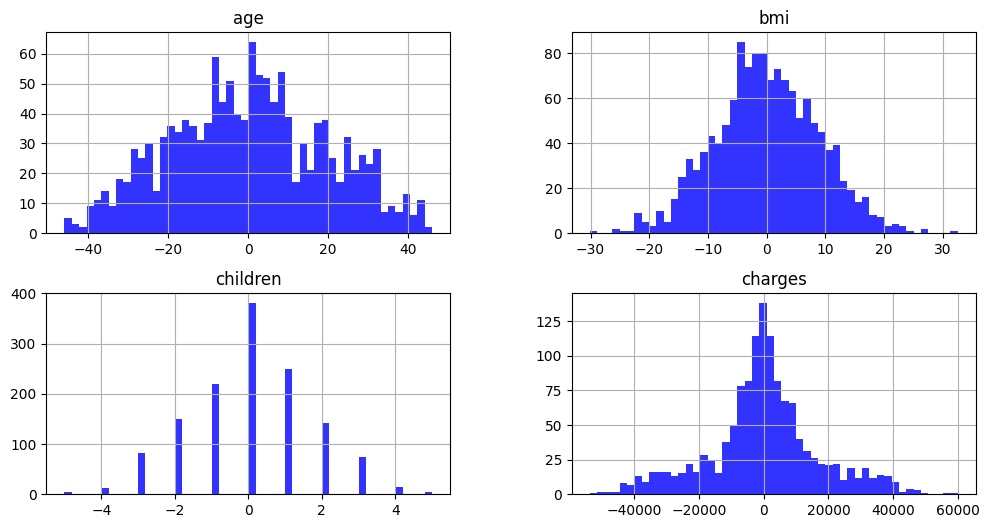

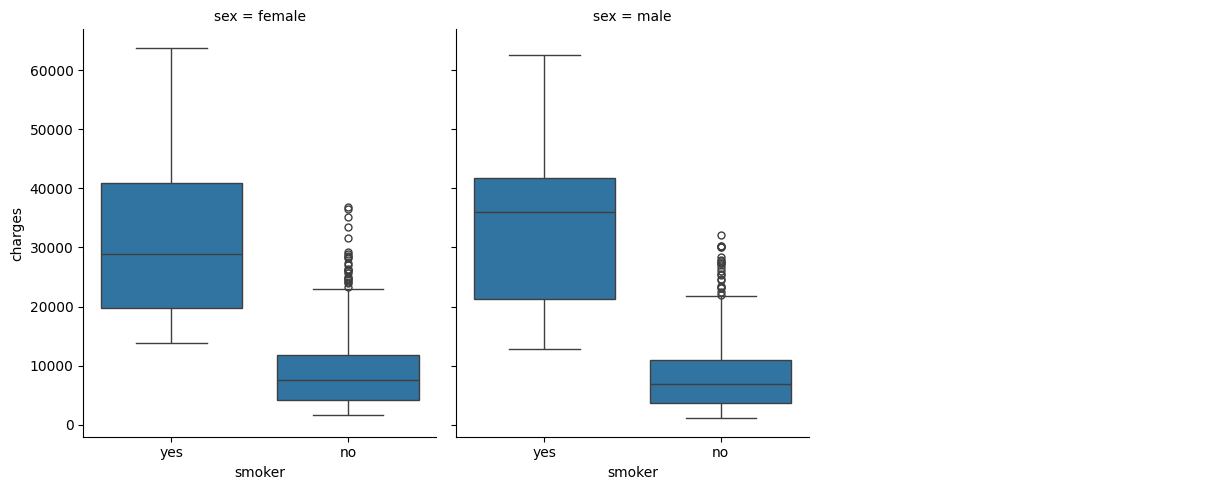

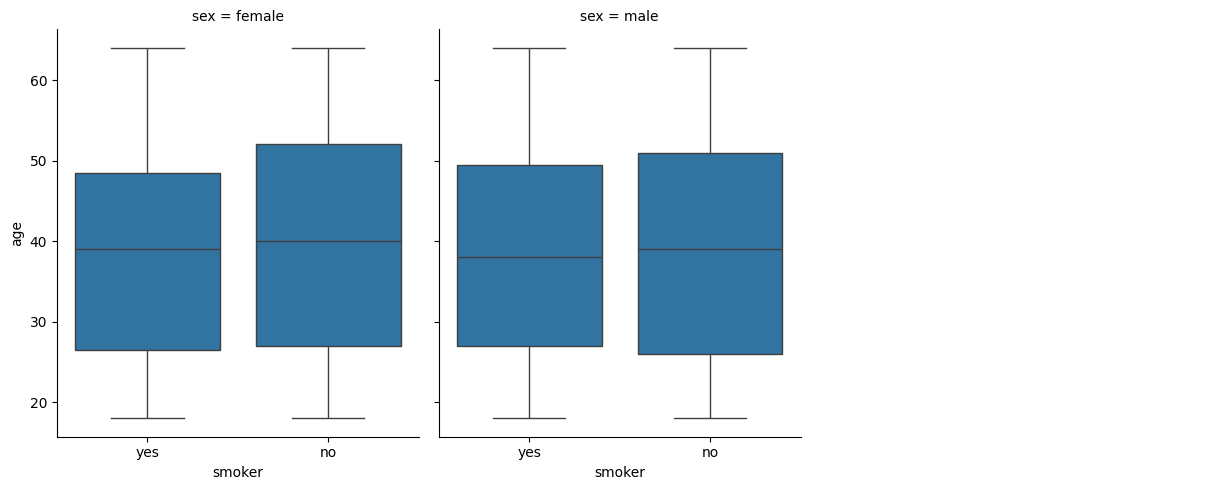

In [ ]:
dataf[['age', 'bmi', 'children', 'charges']].diff().hist(color='b', alpha=0.8, bins=50, figsize=(12, 6))
plt.show()

sns.catplot(x="smoker", y="charges", col_wrap=3, col="sex", data=dataf, kind="box", height=5, aspect=0.8)
plt.show()
sns.catplot(x="smoker", y="age", col_wrap=3, col="sex", data=dataf, kind="box", height=5, aspect=0.8)
plt.show()

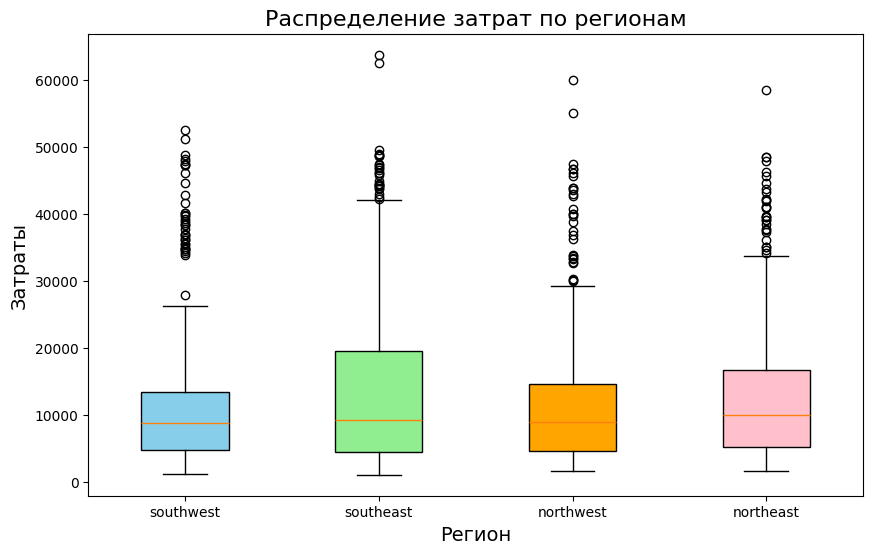

In [ ]:
regions = dataf["region"].unique()
region_data = [dataf[dataf["region"] == region]["charges"] for region in regions]

fig, ax = plt.subplots(figsize=(10, 6))  # Размер графика
box = ax.boxplot(region_data, patch_artist=True, vert=True, labels=regions)

colors = ['skyblue', 'lightgreen', 'orange', 'pink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title("Распределение затрат по регионам", fontsize=16)
ax.set_xlabel("Регион", fontsize=14)
ax.set_ylabel("Затраты", fontsize=14)

plt.show()

In [ ]:
for c in dataf.columns:
    if dataf[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(dataf[c].values))
        dataf[c] = lbl.transform(dataf[c].values)

print(dataf.head())

   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520


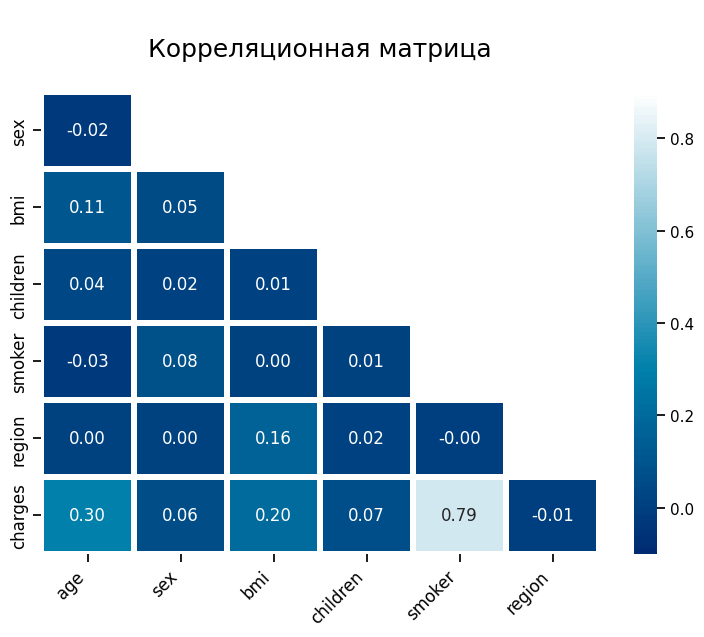

In [ ]:
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(9,6))
corr=dataf.corr()
# Создаем масочку для среза матрицы по нижнему треугольнику
mask=np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr=corr.iloc[1:,:-1].copy()
ax=sns.heatmap(corr, mask=mask, vmin=-.1, vmax=.9, center=0, annot=True, fmt='.2f',
               cmap='ocean', linewidths=4, annot_kws={"fontsize":12})
ax.set_title('\nКорреляционная матрица\n', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.show()

In [ ]:
X = dataf.drop(['charges'], axis=1)
y = dataf['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test", y_test.shape)

Shape of X_train:  (1070, 6)
Shape of X_test:  (268, 6)
Shape of y_train:  (1070,)
Shape of y_test (268,)


In [ ]:
models = {}
model_info = []
feature_importance = {}

boosting = GradientBoostingRegressor(random_state=52)
xg_boosting = XGBRegressor(random_state=52)
cat_boosting = CatBoostRegressor(random_state=52, silent=True)

models['GradientBoostingRegressor'] = boosting
models['XGBoostingRegressor'] = xg_boosting
models['CatBoostRegressor'] = cat_boosting

grid = {'learning_rate': [0.001, 0.01, 0.1, 0.2],
        'n_estimators': [int(x) for x in np.linspace(start=200, stop=500, num=5)],
        'subsample': [0.5, 0.8, 1],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_depth': [int(x) for x in np.linspace(2, 10, num=5)],
        'max_features': ['sqrt']}

xg_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=500, num=5)],
    'colsample_bytree': [0.5, 0.8, 1],
    'reg_lambda': [1, 3, 5],
}

cat_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=500, num=5)],
    'subsample': [0.5, 0.8, 1],
    'l2_leaf_reg': [3, 5, 7],
    'max_depth': [int(x) for x in np.linspace(2, 10, num=5)],
}

In [ ]:
def evaluate(param: dict, model_name: str, model):
    print(model_name)
    xgb_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions=param,
        scoring='neg_mean_squared_error',
        n_iter=100,
        cv=3,
        random_state=52,
        n_jobs=-1)
    xgb_cv.fit(X_train, y_train)
    return xgb_cv.best_params_ #, xgb_cv.best_estimator_.feature_importances_


def get_info(model_name: str, model, param):
    print(model_name)
    model.set_params(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    model_info.append((model_name, rmse, r2, adj_r2))
    #feature_importance[f"Importance_{model_name}"] = feature

    print("Test Error of (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2 * 100, adj_r2 * 100))

In [ ]:
for name, model in models.items():
    # if name == 'GradientBoostingRegressor':
    #     param = grid
    # elif name == 'XGBoostingRegressor':
    #     param = xg_grid
    # else:
    #     param = cat_grid
    # result, features = evaluate(param, name, model)
    gbr = {'subsample': 0.5, 'n_estimators': 275, 'min_samples_split': 10, 'min_samples_leaf': 4,
           'max_features': 'sqrt', 'max_depth': 2, 'learning_rate': 0.1}
    xg = {'reg_lambda': 5, 'n_estimators': 425, 'learning_rate': 0.01, 'colsample_bytree': 1}
    cat = {'subsample': 1, 'n_estimators': 275, 'max_depth': 2, 'learning_rate': 0.1, 'l2_leaf_reg': 5}
    if name == 'GradientBoostingRegressor':
        result = gbr
    elif name == 'XGBoostingRegressor':
        result = xg
    else:
        result = cat
    #get_info(name, model, features, result)
    get_info(name, model, result)

GradientBoostingRegressor
Test Error of (RMSE) = 4,954.76
R-Squared = 80.50%, Adjusted R-Squared = 80.05%
XGBoostingRegressor
Test Error of (RMSE) = 4,835.74
R-Squared = 81.43%, Adjusted R-Squared = 81.00%
CatBoostRegressor
Test Error of (RMSE) = 4,760.61
R-Squared = 82.00%, Adjusted R-Squared = 81.59%


In [ ]:
comparison = pd.DataFrame(data=model_info, columns=['Model', 'RMSE', 'R2', 'Adjusted R2', ])
print(comparison)

                       Model     RMSE        R2  Adjusted R2
0  GradientBoostingRegressor  4954.76  0.805032     0.800550
1        XGBoostingRegressor  4835.74  0.814287     0.810017
2          CatBoostRegressor  4760.61  0.820012     0.815874
